In [3]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
from scipy.signal import butter, filtfilt
from sklearn.model_selection import train_test_split  
import numpy as np
import matplotlib.pyplot as plt
import pickle

print(f"PyTorch version: {torch.__version__}")
print(f"Torchvision version: {torchvision.__version__}")
print(f"Numpy version: {np.__version__}")

PyTorch version: 2.5.1
Torchvision version: 0.20.1
Numpy version: 1.26.4


In [32]:
## Importation des données puis formatage pour l'entrainement

#load data from data.pkl in a tensor
with open('data.pkl', 'rb') as file: #récupération des données
    data = pickle.load(file)

#filtrage des signaux EEG
# Définir les fréquences de coupure et de la fréquence d'échantillonnage du signal
low_cutoff = 0.53
high_cutoff = 40
sample_rate = 173.61

# Conception du filtre passe-bande
nyquist = 0.5 * sample_rate
low = low_cutoff / nyquist
high = high_cutoff / nyquist
b, a = butter(4, [low, high], btype='band')

# Séparer les labels des données
labels = data[:, 0]  # La première colonne correspond aux labels
signals = data[:, 1:]  # Les colonnes restantes sont les données à filtrer

# Appliquer le filtre passe-bande aux données
filtered_signals = filtfilt(b, a, signals, axis=1)

# Faire une copie des signaux filtrés pour éviter les strides négatifs
filtered_signals = filtered_signals.copy()

# Créer un Dataset personnalisé
class EEGDataset(torch.utils.data.Dataset):
    def __init__(self, signals, labels):
        self.signals = torch.tensor(signals, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.signals)

    def __getitem__(self, idx):
        return self.signals[idx], self.labels[idx]

# Créer le dataset personnalisé
dataset = EEGDataset(filtered_signals, labels)

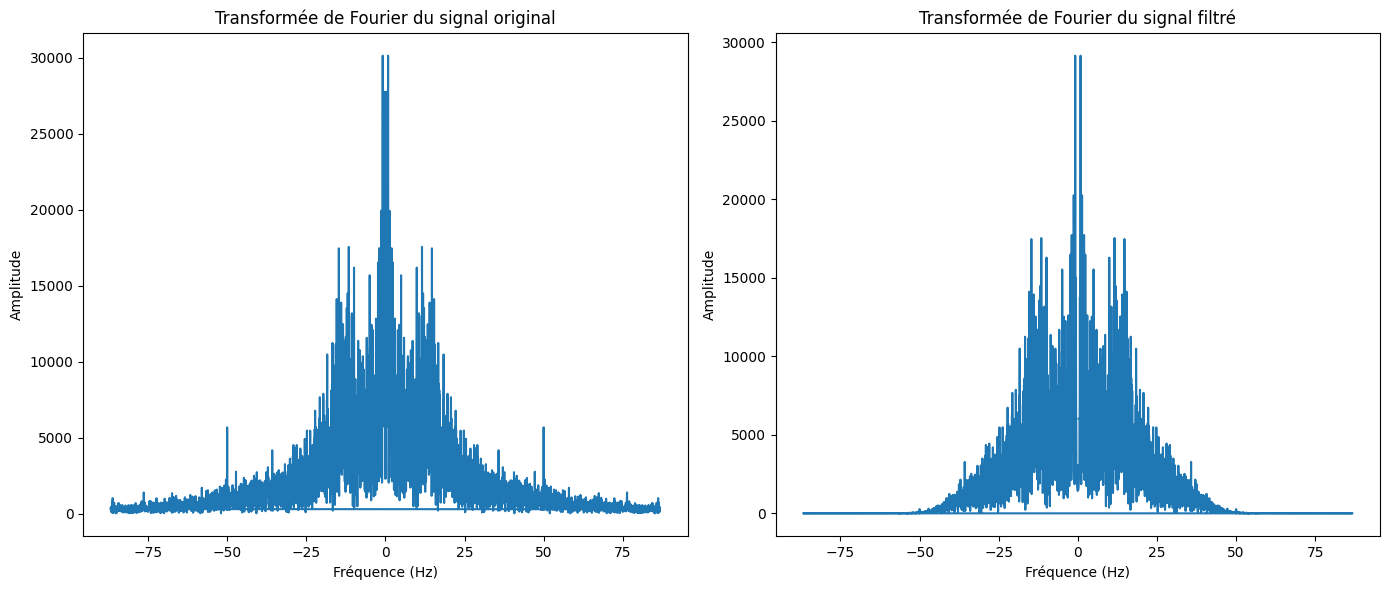

In [22]:
#Comparaison visuelle du signal filtré et original
# Sélectionner un signal aléatoire
random_index = np.random.randint(0, data.shape[0])
original_signal = data[random_index]
filtered_signal = filtered_data[random_index]

# Calculer la transformée de Fourier
original_fft = np.fft.fft(original_signal)
filtered_fft = np.fft.fft(filtered_signal)

# Calculer les fréquences correspondantes
freqs = np.fft.fftfreq(len(original_signal), d=1/sample_rate)

# Afficher les résultats
plt.figure(figsize=(14, 6))

# Transformée de Fourier du signal original
plt.subplot(1, 2, 1)
plt.plot(freqs, np.abs(original_fft))
plt.title('Transformée de Fourier du signal original')
plt.xlabel('Fréquence (Hz)')
plt.ylabel('Amplitude')

# Transformée de Fourier du signal filtré
plt.subplot(1, 2, 2)
plt.plot(freqs, np.abs(filtered_fft))
plt.title('Transformée de Fourier du signal filtré')
plt.xlabel('Fréquence (Hz)')
plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()

In [36]:
# Diviser les données en ensembles d'entraînement, de validation et de test
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_data, val_data, test_data = random_split(dataset, [train_size, val_size, test_size])

# Préparer les DataLoader
batch_size = 10
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)


print("Ensemble d'entraînement :", len(train_data))  
print("Ensemble de validation :", len(val_data))  
print("Ensemble de test :", len(test_data))

Ensemble d'entraînement : 400
Ensemble de validation : 50
Ensemble de test : 50


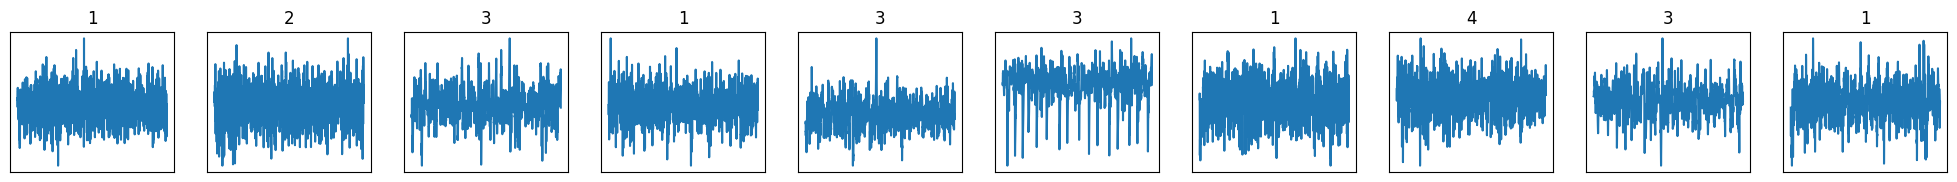

In [37]:

# Sélectionner un batch aléatoire de signaux d'entraînement
dataiter = iter(train_loader)
signals, labels = next(dataiter)
signals = signals.numpy()

# Afficher les signaux dans le batch, avec les labels correspondants
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(min(batch_size, 20)):  # Afficher jusqu'à 20 signaux
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    ax.plot(signals[idx])
    ax.set_title(str(int(labels[idx].item())))
plt.show()